In [2]:
setwd("/frazer01/projects/CARDIPS/analysis/cardiac_gwas_coloc")

source("script/functions.R"  )


In [3]:
library(ashr , lib.loc = "/frazer01/home/jennifer/software/R-4.1.0/lib64/R/library")
library(mashr, lib.loc = "/frazer01/home/jennifer/software/R-4.1.0/lib64/R/library")


Warning message:
“package ‘ashr’ was built under R version 4.1.0”
Warning message:
“package ‘mashr’ was built under R version 4.1.0”


In [4]:
dir.create("pipeline/eqtls.0.2.coloc_gwas_mash"     , showWarnings = FALSE)
dir.create("pipeline/eqtls.0.2.coloc_gwas_mash/loci", showWarnings = FALSE)


In [5]:
load("/frazer01/home/jennifer/jn_projects/cvpc_eqtls/pipeline/3.2.eqtls/mashr/mash_data.beta_se_from_independent.robj", verbose = TRUE)

Loading objects:
  data


In [6]:
lfsr           = get_lfsr(data$output)
colnames(lfsr) = sub("ipscore", "ipsc_cvpc", colnames(lfsr))
colnames(lfsr) = paste("mash", colnames(lfsr), sep = ".")

In [7]:
qtl_list = readRDS("/frazer01/projects/CARDIPS/analysis/cardiac_qtls_combined/input/qtl/qtls.RDS"   )
exp_list = readRDS("/frazer01/projects/CARDIPS/analysis/cardiac_qtls_combined/input/expdata_qtl.rds")

In [8]:
phenotypes     = qtl_list$phenotypes[c("rna", "isoform"),]
qtls           = qtl_list$qtl$rna
qtls           = qtls[ qtls$egene == TRUE, ]
qtls$trid      = paste(qtls$transcript_id, qtls$id  )
qtls$tr2type   = paste(qtls$transcript_id, qtls$type)

In [9]:
coloc         = fread("pipeline/eqtls.0.1.coloc_gwas/coloc.txt", sep = "\t", header = TRUE, data.table = FALSE)
coloc$tr2type = paste(coloc$transcript_id, coloc$type)
coloc$trid    = NULL
coloc         = merge(coloc, qtls[, c("trid", "tr2type")], by = "tr2type", all.x = TRUE)

In [10]:
manifest           = add_rownames(fread("pipeline/eqtls.0.1.coloc_gwas/manifest.txt", sep = "\t", header = TRUE, data.table = FALSE))


# Annotate eQTLs with mash tissues

In [11]:
pvals           = data.frame(pval = c(0.05, 0.01, 0.001, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-15, 1e-20, 1e-30), id = "")
pvals$id        = paste("pval", -log10(pvals$pval), sep = "_")
pvals$id[[1]]   = "pval005"
rownames(pvals) = pvals$id

In [12]:
mash_counts = as.data.frame(rbindlist(lapply(pvals$id, function(id)
{
    pval = pvals[ id, "pval"]
    lfsr = as.data.frame(ifelse(lfsr > pval, yes = 0, no = 1))
    out  = as.data.frame(t(as.matrix(colSums(lfsr))))
    
    return(out)
})), stringsAsFactors = FALSE)

mash_counts = cbind(pvals, mash_counts)

In [13]:
nrow(lfsr)
mash_counts

[1] 17811

,pval,id,mash.arteria_aorta,mash.arteria_coronary,mash.heart_atrium,mash.heart_ventricle,mash.ipsc_cvpc
,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
pval005,5e-02,pval005,12813,11645,12671,12007,8856
pval_2,1e-02,pval_2,10186,8472,9820,9023,5635
pval_3,1e-03,pval_3,7652,5599,7116,6386,3440
pval_4,1e-04,pval_4,6044,3941,5381,4824,2380
pval_5,1e-05,pval_5,4918,2858,4237,3723,1743
pval_6,1e-06,pval_6,4103,2067,3391,2966,1323
pval_7,1e-07,pval_7,3442,1576,2757,2467,1022
pval_8,1e-08,pval_8,2947,1248,2285,2062,815
pval_9,1e-09,pval_9,2487,989,1924,1771,646


In [14]:
coloc2mash = lapply(pvals$id, function(id)
{
    pval                = pvals[ id, "pval"]
    lfsr                = as.data.frame(ifelse(lfsr > pval, yes = 0, no = 1))
    coloc               = merge(coloc, lfsr, by.x = "trid", by.y = "row.names")
    
    lfsr_spec           = as.matrix(lfsr)
    colnames(lfsr_spec) = sub("^mash", "mash_specific", colnames(lfsr_spec))
    
    lfsr_spec[ rowSums(lfsr_spec) > 1, ] = 0
    
    coloc = merge(coloc, lfsr_spec, by.x = "trid", by.y = "row.names")
    
    return(coloc)
})

names(coloc2mash) = pvals$id

# Test enrichments for LFSR on tissues

In [15]:
colordata_tissue  = exp_list[["color"]][["by_tissue"]]
mycombs           = expand.grid(body_site = colordata_tissue$body_site, analysis = c("mash", "mash_specific"), stringsAsFactors = FALSE)
mycombs$colname   = paste(mycombs$analysis, mycombs$body_site, sep = ".")
rownames(mycombs) = mycombs$colname

In [16]:
mycombs

,body_site,analysis,colname
,<chr>,<chr>,<chr>
mash.ipsc_cvpc,ipsc_cvpc,mash,mash.ipsc_cvpc
mash.heart_atrium,heart_atrium,mash,mash.heart_atrium
mash.heart_ventricle,heart_ventricle,mash,mash.heart_ventricle
mash.arteria_aorta,arteria_aorta,mash,mash.arteria_aorta
mash.arteria_coronary,arteria_coronary,mash,mash.arteria_coronary
mash_specific.ipsc_cvpc,ipsc_cvpc,mash_specific,mash_specific.ipsc_cvpc
mash_specific.heart_atrium,heart_atrium,mash_specific,mash_specific.heart_atrium
mash_specific.heart_ventricle,heart_ventricle,mash_specific,mash_specific.heart_ventricle
mash_specific.arteria_aorta,arteria_aorta,mash_specific,mash_specific.arteria_aorta


In [17]:
calculate_enrichment = function(trait, id, colname, pvals, mycombs, coloc, thresholds = (1:19) / 20)
{
    cell     = mycombs[ colname, "body_site"]
    analysis = mycombs[ colname, "analysis" ]
    pval     = pvals  [ id     , "pval"     ]
    coloc    = coloc  [ coloc$gwas == trait,]
    tests    = as.data.frame(rbindlist(lapply(thresholds, function(threshold)
    {
        totest = matrix(c(nrow(coloc[ coloc$PP.H4.abf >= threshold & coloc[, paste(analysis, cell, sep = ".")] == 1, ]),
                          nrow(coloc[ coloc$PP.H4.abf >= threshold & coloc[, paste(analysis, cell, sep = ".")] == 0, ]),
                          nrow(coloc[ coloc$PP.H4.abf <  threshold & coloc[, paste(analysis, cell, sep = ".")] == 1, ]),
                          nrow(coloc[ coloc$PP.H4.abf <  threshold & coloc[, paste(analysis, cell, sep = ".")] == 0, ])
                         ), nrow = 2, byrow = TRUE)
        
        test = fisher.test(totest)
        out  = data.frame(trait = trait, cell = cell, analysis = analysis, lfsr = pval, threshold = threshold, 
                          x11 = totest[1,1], x12 = totest[1,2], x21 = totest[2,1], x22 = totest[2,2],
                          estimate = test$estimate, ci1 = test$conf.int[[1]], ci2 = test$conf.int[[2]], pval = test$p.value
                         )
                      
        return(out)
    })), stringsAsFactors = FALSE)
    
    return(tests)
}

trait    = "continuous-PP-both_sexes-combined_medadj_irnt"
colname  = "mash.ipsc_cvpc"
id       = pvals[1, "id"]

enr1 = as.data.frame(rbindlist(lapply(sort(unique(coloc$gwas)), function(trait)
{
    as.data.frame(rbindlist(lapply(pvals$id, function(id)
    {
        as.data.frame(rbindlist(lapply(mycombs$colname, function(colname)
        {
            #message(paste(trait, id, colname), appendLF = FALSE)
            calculate_enrichment(trait, id, colname, pvals, mycombs, coloc2mash[[id]])
        })), stringsAsFactors = FALSE)
    })), stringsAsFactors = FALSE)
})), stringsAsFactors = FALSE)

enr1$log2r = log2(enr1$estimate)

enr1[is.nan(enr1$log2r) == TRUE, "log2r"] = 0

In [18]:
fwrite(enr1, "pipeline/eqtls.0.2.coloc_gwas_mash/enrichment_by_pp.txt", sep = "\t", col.names = TRUE, row.names = FALSE)

In [19]:
str(enr1)

'data.frame':	12350 obs. of  14 variables:
 $ trait    : chr  "continuous-102-both_sexes-irnt" "continuous-102-both_sexes-irnt" "continuous-102-both_sexes-irnt" "continuous-102-both_sexes-irnt" ...
 $ cell     : chr  "ipsc_cvpc" "ipsc_cvpc" "ipsc_cvpc" "ipsc_cvpc" ...
 $ analysis : chr  "mash" "mash" "mash" "mash" ...
 $ lfsr     : num  0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 ...
 $ threshold: num  0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 ...
 $ x11      : int  128 101 92 85 80 78 75 70 68 64 ...
 $ x12      : int  129 83 68 64 57 55 52 48 48 48 ...
 $ x21      : int  288 315 324 331 336 338 341 346 348 352 ...
 $ x22      : int  286 332 347 351 358 360 363 367 367 367 ...
 $ estimate : num  0.985 1.282 1.448 1.408 1.495 ...
 $ ci1      : num  0.726 0.911 1.009 0.97 1.016 ...
 $ ci2      : num  1.34 1.81 2.09 2.05 2.21 ...
 $ pval     : num  0.9403 0.1555 0.0428 0.0703 0.0395 ...
 $ log2r    : num  -0.0213 0.3586 0.5344 0.4934 0.5798 ...


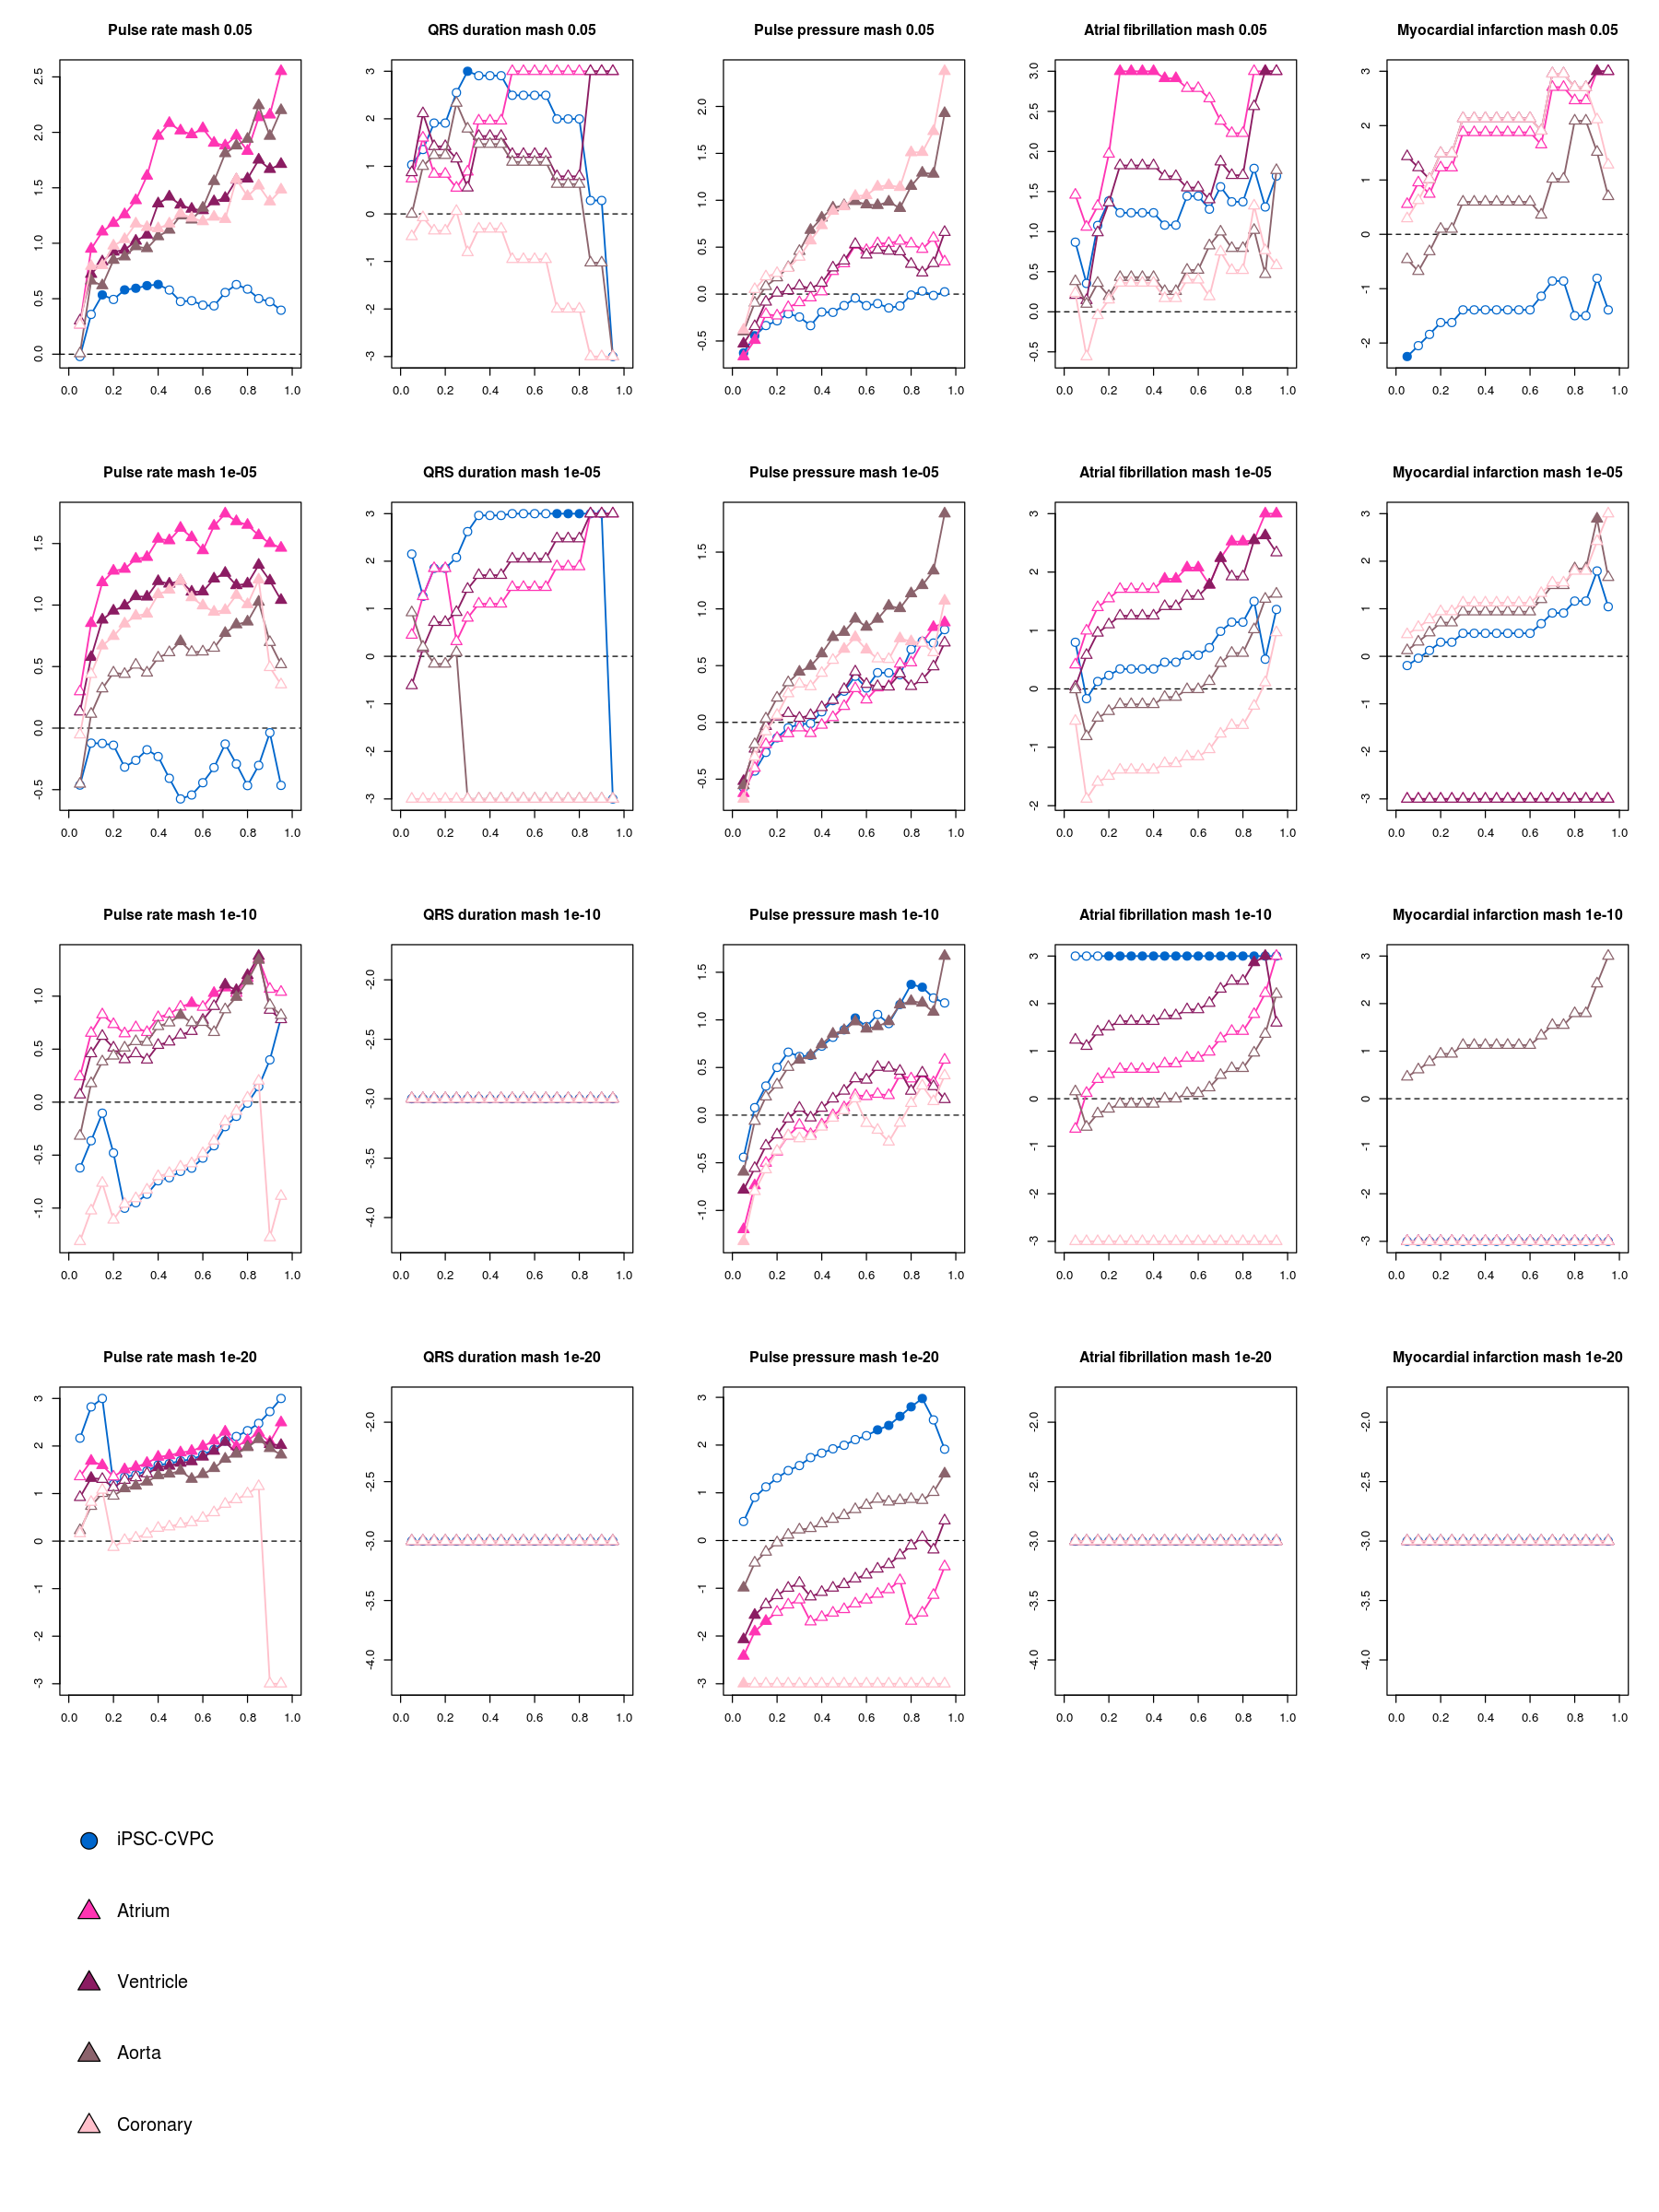

In [25]:
plot_enrichment = function(trait, id, analysis, enr1, colordata)
{
    lfsr     = pvals  [ id     , "pval"     ]
    x        = enr1[ enr1$trait == trait & enr1$lfsr == lfsr & enr1$analysis == analysis, ]
    
    if(nrow(x[ x$log2r >=  3, ]) > 0){x[ x$log2r >=  3, "log2r"] =  3}
    if(nrow(x[ x$log2r <= -3, ]) > 0){x[ x$log2r <= -3, "log2r"] = -3}
    
    plot(1,1, type = "n", xlim = c(0,1), ylim = range(x$log2r), xlab = "", ylab = "", main = paste(manifest[trait, "name"], analysis, lfsr))
    
    abline(h = 0, lty = "dashed")
    
    for (cell in colordata$body_site)
    {
        toplot = x[ x$cell == cell,]
        color  = colordata[ colordata$body_site == cell, "color"]
        pch    = colordata[ colordata$body_site == cell, "pch"  ]
        toplot$bg = "#ffffff"
        
        if(nrow(toplot[toplot$pval <= 0.05,]) > 0){toplot[toplot$pval <= 0.05, "bg"] = color}
        
        lines (x = toplot$threshold, y = toplot$log2r, col = color, lwd =  1.5)
        points(x = toplot$threshold, y = toplot$log2r, col = color, pch = pch, bg = toplot$bg, cex = 1.5)
    }
}

colordata     = colordata_tissue
colordata$pch = c(21, rep(24, nrow(colordata) - 1))
trait         = "continuous-PP-both_sexes-combined_medadj_irnt"
analysis      = "mash"
id            = pvals[1, "id"]

options(repr.plot.width = 15, repr.plot.height = 20)

#a = plot_enrichment(trait, id, analysis, enr1, colordata)

layout(matrix(1:25, nrow = 5, byrow = TRUE))

#invisible(lapply(sort(unique(mycombs$analysis)), function(analysis)
invisible(lapply(c("mash"), function(analysis)
{
    #invisible(lapply(pvals$id, function(id)
    invisible(lapply(c("pval005", "pval_5", "pval_10", "pval_20"), function(id)
    {
        invisible(lapply(sort(unique(coloc$gwas)), function(trait)
        {
            #message(paste(trait, id, analysis), appendLF = FALSE)
            plot_enrichment(trait, id, analysis, enr1, colordata)
        }))
    }))
}))

#layout(1)
plot(1,1, type = "n", xlim = c(-0.1,1), ylim = c(nrow(colordata), 1), xlab = "", ylab = "", axes = FALSE)

colordata$y = 1:nrow(colordata)

points(x = rep(0  , nrow(colordata)), y = colordata$y, pch    = colordata$pch   , cex = 3  , bg  = colordata$color)
text  (x = rep(0.1, nrow(colordata)), y = colordata$y, labels = colordata$tissue, cex = 1.5, pos = 4)



In [21]:
pvals

,pval,id
,<dbl>,<chr>
pval005,5e-02,pval005
pval_2,1e-02,pval_2
pval_3,1e-03,pval_3
pval_4,1e-04,pval_4
pval_5,1e-05,pval_5
pval_6,1e-06,pval_6
pval_7,1e-07,pval_7
pval_8,1e-08,pval_8
pval_9,1e-09,pval_9


# Count eQTLs from single tissue analyses

In [20]:
tissue2file = colordata
tissue2file$file = paste0("/frazer01/home/jennifer/jn_projects/cvpc_eqtls/pipeline/3.2.eqtls/eqtls/", tissue2file$body_site, ".gene.egenes.txt")
tissue2file[ "ipsc_cvpc", "file"] = sub("ipsc_cvpc", "ipscore", tissue2file[ "ipsc_cvpc", "file"])

In [21]:
tissue2qtl_list = lapply(tissue2file$body_site, function(tissue)
{
    indata = fread(tissue2file[ tissue, "file"], sep = "\t", header = TRUE, data.table = FALSE)
    
    message(tissue, appendLF = FALSE)
    message(paste("genes", length(unique(indata$transcript_id)), sep = " = "), appendLF = FALSE)
    invisible(lapply(0:5, function(type)
    {
        this = indata[ indata$type == type & indata$egene == TRUE, ]
        message(paste("type", type, length(unique(this$transcript_id)), sep = " = "), appendLF = FALSE)
    }))
    
    return(indata)
})

names(tissue2qtl_list) = tissue2file$body_site

ipsc_cvpc
genes = 15877
type = 0 = 3393
type = 1 = 272
type = 2 = 10
type = 3 = 3
type = 4 = 3
type = 5 = 1
heart_atrium
genes = 18210
type = 0 = 7148
type = 1 = 1319
type = 2 = 233
type = 3 = 44
type = 4 = 15
type = 5 = 11
heart_ventricle
genes = 16158
type = 0 = 5951
type = 1 = 1109
type = 2 = 200
type = 3 = 61
type = 4 = 27
type = 5 = 5
arteria_aorta
genes = 19930
type = 0 = 9812
type = 1 = 2418
type = 2 = 576
type = 3 = 171
type = 4 = 39
type = 5 = 13
arteria_coronary
genes = 20658
type = 0 = 5458
type = 1 = 607
type = 2 = 70
type = 3 = 4
type = 4 = 4
type = 5 = 0


In [22]:
tissue2qtl = as.data.frame(rbindlist(lapply(tissue2file$body_site, function(tissue)
{
    indata = tissue2qtl_list[[tissue]]
    out = data.frame(body_site = tissue, n_genes = length(unique(indata$transcript_id)))
    
    for(type in 0:5)
    {
        this = indata[ indata$type == type & indata$egene == TRUE, ]
        out[, paste("type", type, sep = "_")] = length(unique(this$transcript_id))
    }
    
    return(out)
})), stringsAsFactors = FALSE)

tissue2qtl$tot         = rowSums(tissue2qtl[, paste("type", 0:5, sep = "_")])
tissue2qtl$conditional = rowSums(tissue2qtl[, paste("type", 1:5, sep = "_")])


In [23]:
tissue2qtl

body_site,n_genes,type_0,type_1,type_2,type_3,type_4,type_5,tot,conditional
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
ipsc_cvpc,15877,3393,272,10,3,3,1,3682,289
heart_atrium,18210,7148,1319,233,44,15,11,8770,1622
heart_ventricle,16158,5951,1109,200,61,27,5,7353,1402
arteria_aorta,19930,9812,2418,576,171,39,13,13029,3217
arteria_coronary,20658,5458,607,70,4,4,0,6143,685


# Write supplemental tables

In [24]:
manuscript_version = "V08"
outfolder          = paste("manuscript_eqtl", manuscript_version, sep = "/")


In [25]:
table_sx1           = add_rownames(merge(colordata[, c("body_site", "tissue")], tissue2qtl))
colnames(table_sx1) = c("Tissue", "Expressed genes", "Primary", paste("Conditional", 1:5), "Total eQTL signals", "Total conditional eQTL signals")

table_sx2           = mash_counts
table_sx2$id        = NULL
colnames(table_sx2) = sub("mash\\.", "", colnames(table_sx2))

for(bs in colordata$body_site)
{
    colnames(table_sx2) = sub(bs, colordata[ bs, "tissue"], colnames(table_sx2))
}

colnames(table_sx2)[[1]] = "lfsr threshold"

table_sx1
table_sx2

fwrite(table_sx1, paste(outfolder, "Table_SX1.csv", sep = "/"), sep = ",", col.names = TRUE, row.names = FALSE)
fwrite(table_sx2, paste(outfolder, "Table_SX2.csv", sep = "/"), sep = ",", col.names = TRUE, row.names = FALSE)

,Tissue,Expressed genes,Primary,Conditional 1,Conditional 2,Conditional 3,Conditional 4,Conditional 5,Total eQTL signals,Total conditional eQTL signals
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
arteria_aorta,Aorta,19930,9812,2418,576,171,39,13,13029,3217
arteria_coronary,Coronary,20658,5458,607,70,4,4,0,6143,685
heart_atrium,Atrium,18210,7148,1319,233,44,15,11,8770,1622
heart_ventricle,Ventricle,16158,5951,1109,200,61,27,5,7353,1402
ipsc_cvpc,iPSC-CVPC,15877,3393,272,10,3,3,1,3682,289


,lfsr threshold,Aorta,Coronary,Atrium,Ventricle,iPSC-CVPC
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
pval005,5e-02,12813,11645,12671,12007,8856
pval_2,1e-02,10186,8472,9820,9023,5635
pval_3,1e-03,7652,5599,7116,6386,3440
pval_4,1e-04,6044,3941,5381,4824,2380
pval_5,1e-05,4918,2858,4237,3723,1743
pval_6,1e-06,4103,2067,3391,2966,1323
pval_7,1e-07,3442,1576,2757,2467,1022
pval_8,1e-08,2947,1248,2285,2062,815
pval_9,1e-09,2487,989,1924,1771,646


In [26]:
tissue2qtl
mash_counts

body_site,n_genes,type_0,type_1,type_2,type_3,type_4,type_5,tot,conditional
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
ipsc_cvpc,15877,3393,272,10,3,3,1,3682,289
heart_atrium,18210,7148,1319,233,44,15,11,8770,1622
heart_ventricle,16158,5951,1109,200,61,27,5,7353,1402
arteria_aorta,19930,9812,2418,576,171,39,13,13029,3217
arteria_coronary,20658,5458,607,70,4,4,0,6143,685


,pval,id,mash.arteria_aorta,mash.arteria_coronary,mash.heart_atrium,mash.heart_ventricle,mash.ipsc_cvpc
,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
pval005,5e-02,pval005,12813,11645,12671,12007,8856
pval_2,1e-02,pval_2,10186,8472,9820,9023,5635
pval_3,1e-03,pval_3,7652,5599,7116,6386,3440
pval_4,1e-04,pval_4,6044,3941,5381,4824,2380
pval_5,1e-05,pval_5,4918,2858,4237,3723,1743
pval_6,1e-06,pval_6,4103,2067,3391,2966,1323
pval_7,1e-07,pval_7,3442,1576,2757,2467,1022
pval_8,1e-08,pval_8,2947,1248,2285,2062,815
pval_9,1e-09,pval_9,2487,989,1924,1771,646


In [40]:
str(qtls)

'data.frame':	18030 obs. of  32 variables:
 $ id             : chr  "VAR_1_100071637_T_C" "VAR_1_100079353_A_C" "VAR_1_100323343_C_CAGAGGGAGACCGTGGGGAGGAGGAGGGGGG" "VAR_1_100323343_C_CAGAGGGAGACCGTGGGGAGGAGGAGGGGGG" ...
 $ transcript_id  : chr  "ENSG00000099260.11_5" "ENSG00000099260.11_5" "ENSG00000137996.12_3" "ENSG00000156876.10_6" ...
 $ gene_id        : chr  "ENSG00000099260.11_5" "ENSG00000099260.11_5" "ENSG00000137996.12_3" "ENSG00000156876.10_6" ...
 $ gene_name      : chr  "PALMD" "PALMD" "RTCA" "SASS6" ...
 $ gene_type      : chr  "protein_coding" "protein_coding" "protein_coding" "protein_coding" ...
 $ start          : int  100111669 100111669 100731763 100549119 100614005 100434907 100549119 100731763 100315917 9732484 ...
 $ end            : int  100160097 100160097 100758325 100598511 100643829 100501190 100598511 100758325 100389579 9747613 ...
 $ strand         : chr  "+" "+" "+" "-" ...
 $ chrom          : int  1 1 1 1 1 1 1 1 1 1 ...
 $ pos            : int  10007163

# Combined analysis

In [66]:
ints         = qtl_list$interactions$rna
ints         = ints[ ints$cell == TRUE & grepl("cibersort", ints$interaction) == FALSE,]
ints$tr2type = paste(ints$transcript_id, ints$type)

In [69]:
str(ints)
sort(unique(ints$interaction))


'data.frame':	3111 obs. of  40 variables:
 $ transcript_id: chr  "ENSG00000001460.18_7" "ENSG00000001461.17_4" "ENSG00000001561.7_4" "ENSG00000003393.15_8" ...
 $ gene_id      : chr  "ENSG00000001460.18_7" "ENSG00000001461.17_4" "ENSG00000001561.7_4" "ENSG00000003393.15_8" ...
 $ gene_name    : chr  "STPG1" "NIPAL3" "ENPP4" "ALS2" ...
 $ gene_type    : chr  "protein_coding" "protein_coding" "protein_coding" "protein_coding" ...
 $ start        : int  24683489 24742292 46097726 202564990 3360491 97920962 15964699 134467091 38175350 38175350 ...
 $ end          : int  24743424 24799466 46114425 202645679 3400452 98030402 16086001 134584183 38217468 38217468 ...
 $ strand       : chr  "-" "+" "+" "-" ...
 $ chrom        : int  1 1 6 2 11 7 4 8 17 17 ...
 $ pos          : int  24731659 24759685 46188023 202654632 3386412 97915635 16032948 134604069 38188844 38125796 ...
 $ ref          : chr  "G" "G" "C" "TTTG" ...
 $ alt          : chr  "A" "T" "T" "T" ...
 $ rsid         : chr  "rs558965

[1] "adult"            "arteria"          "arteria_aorta"    "arteria_coronary"
[5] "heart"            "heart_atrium"     "heart_ventricle"  "ipsc_cvpc"

In [78]:
calculate_ts = function(tissue, tissue2qtl, qtls, ints)
{
    torem  = tissue2qtl[ tissue2qtl$body_site != tissue, "body_site"]
    
    if(tissue == "ipsc_cvpc"                             ){torem = c(torem, "adult", "heart", "arteria")}
    if(tissue %in% c("arteria_aorta", "arteria_coronary")){torem = c(torem,          "heart"           )}
    if(tissue %in% c("heart_atrium" , "heart_ventricle ")){torem = c(torem,                   "arteria")}
    
    others = unique(ints[ ints$interaction %in% torem, "tr2type"])
    qtls   = qtls[!qtls$tr2type %in% others,]
    out    = data.frame(tissue = tissue, primary = nrow(qtls[ qtls$type == 0,]), conditional = nrow(qtls[ qtls$type > 0,]))
    
    return(out)
}

comb     = as.data.frame(rbindlist(lapply(tissue2qtl$body_site, function(tissue){calculate_ts(tissue, tissue2qtl, qtls, ints)})), stringsAsFactors = FALSE)
comb$tot = rowSums(comb[, c("primary", "conditional")])


In [79]:
comb

tissue,primary,conditional,tot
<chr>,<int>,<int>,<dbl>
ipsc_cvpc,10307,5980,16287
heart_atrium,10714,6084,16798
heart_ventricle,10976,6160,17136
arteria_aorta,10910,6128,17038
arteria_coronary,10639,6057,16696


In [48]:
str(qtls)


'data.frame':	18030 obs. of  32 variables:
 $ id             : chr  "VAR_1_100071637_T_C" "VAR_1_100079353_A_C" "VAR_1_100323343_C_CAGAGGGAGACCGTGGGGAGGAGGAGGGGGG" "VAR_1_100323343_C_CAGAGGGAGACCGTGGGGAGGAGGAGGGGGG" ...
 $ transcript_id  : chr  "ENSG00000099260.11_5" "ENSG00000099260.11_5" "ENSG00000137996.12_3" "ENSG00000156876.10_6" ...
 $ gene_id        : chr  "ENSG00000099260.11_5" "ENSG00000099260.11_5" "ENSG00000137996.12_3" "ENSG00000156876.10_6" ...
 $ gene_name      : chr  "PALMD" "PALMD" "RTCA" "SASS6" ...
 $ gene_type      : chr  "protein_coding" "protein_coding" "protein_coding" "protein_coding" ...
 $ start          : int  100111669 100111669 100731763 100549119 100614005 100434907 100549119 100731763 100315917 9732484 ...
 $ end            : int  100160097 100160097 100758325 100598511 100643829 100501190 100598511 100758325 100389579 9747613 ...
 $ strand         : chr  "+" "+" "+" "-" ...
 $ chrom          : int  1 1 1 1 1 1 1 1 1 1 ...
 $ pos            : int  10007163

# Compare mash with single tissues

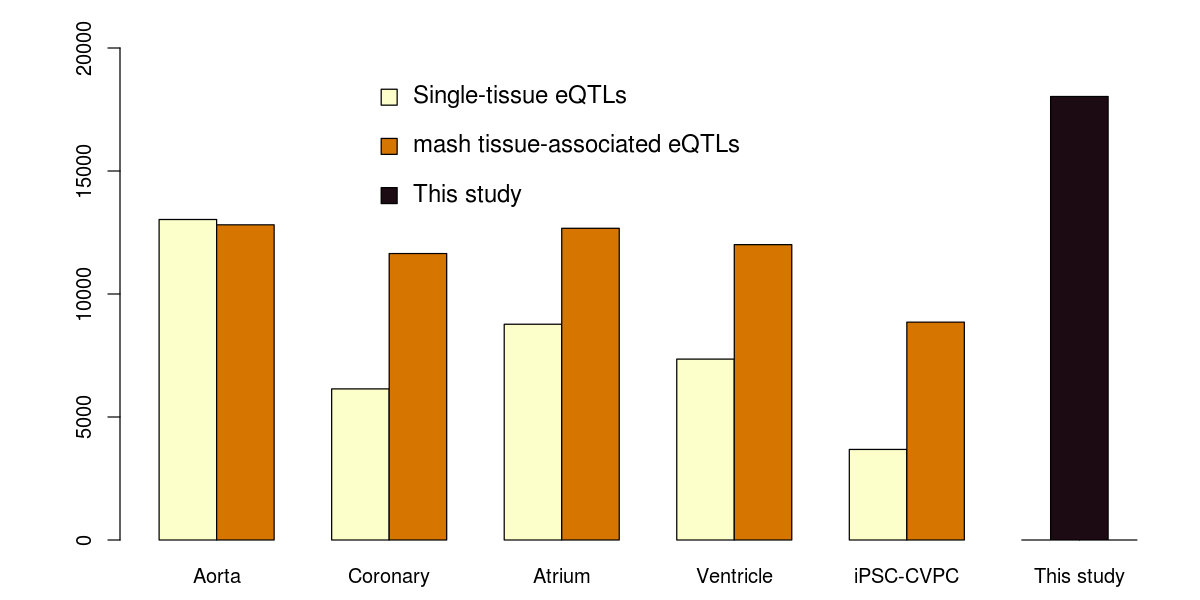

In [27]:
colordata_all    = rbind(colordata[,c("body_site", "tissue", "color", "order")], 
                         data.frame(body_site = "this", tissue = "This study", color = "#bbbbbb", order = 0)
                        )
toplot           = data.frame(body_site = tissue2qtl$body_site, n_single = tissue2qtl$tot, n_mash = as.numeric(as.matrix(mash_counts["pval005", paste("mash", tissue2qtl$body_site, sep = ".")])), n_all = 0)
toplot           = rbind(toplot, data.frame(body_site = "this", n_single = 0, n_mash = 0, n_all = 18030))
toplot           = merge(toplot, colordata_all, all.x = TRUE)
toplot$ratio     = toplot$n_mash / toplot$n_single
rownames(toplot) = toplot$body_site

options(repr.plot.width = 10, repr.plot.height = 5)

par(mar = c(2.5,5,2,1))
barplot(t(toplot[, c("n_single", "n_mash")]), width = 1, space = c(0,1), col = sequential_hcl(n = 3, palette = "La Jolla")[1:2], beside = TRUE , names.arg = toplot$tissue, ylim = c(0,20000))

rect(xleft = 16.5, xright = 17.5, ybottom = 0, ytop = toplot[ "this", "n_all"], col = sequential_hcl(n = 3, palette = "La Jolla")[[3]])

points(x = rep(5  , 3), y = c(18, 16,14) * 1000, pch = 22, bg = sequential_hcl(n = 3, palette = "La Jolla"), cex = 2)
text  (x = rep(5.2, 3), y = c(18, 16,14) * 1000, labels = c("Single-tissue eQTLs", "mash tissue-associated eQTLs", "This study"), pos = 4, cex = 1.2)


In [28]:
toplot

,body_site,n_single,n_mash,n_all,tissue,color,order,ratio
,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
arteria_aorta,arteria_aorta,13029,12813,0,Aorta,#8B636C,4,0.9834216
arteria_coronary,arteria_coronary,6143,11645,0,Coronary,#FFC0CB,5,1.8956536
heart_atrium,heart_atrium,8770,12671,0,Atrium,#FF34B3,2,1.4448119
heart_ventricle,heart_ventricle,7353,12007,0,Ventricle,#8B1C62,3,1.6329389
ipsc_cvpc,ipsc_cvpc,3682,8856,0,iPSC-CVPC,#0066CC,1,2.4052146
this,this,0,0,18030,This study,#bbbbbb,0,NaN
